# Tutorial: Preprocessing waveform audio into log-mel spectrogram

This tutorial notebook uses torchaudio only.

## Downloading FSDKaggle2018

    wget https://zenodo.org/record/2552860/files/FSDKaggle2018.audio_test.zip
    wget https://zenodo.org/record/2552860/files/FSDKaggle2018.audio_train.zip
    wget https://zenodo.org/record/2552860/files/FSDKaggle2018.doc.zip
    wget https://zenodo.org/record/2552860/files/FSDKaggle2018.meta.zip


In [1]:
! wget https://zenodo.org/record/2552860/files/FSDKaggle2018.audio_test.zip
! wget https://zenodo.org/record/2552860/files/FSDKaggle2018.audio_train.zip
! wget https://zenodo.org/record/2552860/files/FSDKaggle2018.doc.zip
! wget https://zenodo.org/record/2552860/files/FSDKaggle2018.meta.zip

--2021-01-18 22:05:30--  https://zenodo.org/record/2552860/files/FSDKaggle2018.audio_test.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 523294304 (499M) [application/octet-stream]
Saving to: ‘FSDKaggle2018.audio_test.zip’

FSDKaggle2018.audio 100%[===================>] 499.05M  14.2MB/s    in 30s     

2021-01-18 22:06:01 (16.5 MB/s) - ‘FSDKaggle2018.audio_test.zip’ saved [523294304/523294304]

--2021-01-18 22:06:01--  https://zenodo.org/record/2552860/files/FSDKaggle2018.audio_train.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4057528787 (3.8G) [application/octet-stream]
Saving to: ‘FSDKaggle2018.audio_train.zip’

FSDKaggle2018.audio 100%[===================>]   3.78G  13.9MB/s    in 5m 1s   

2021-01-18 22:11:03 (12.9

In [61]:
! ls

In [54]:
! unzip -qq FSDKaggle2018.audio_test.zip
! unzip -qq FSDKaggle2018.audio_train.zip
! unzip -qq FSDKaggle2018.doc.zip
! unzip -qq FSDKaggle2018.meta.zip
! mkdir work && mv FSD* work
! ls work

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: FSDKaggle2018.audio_train/79bc77b2.wav  
  inflating: FSDKaggle2018.audio_train/79be82bb.wav  
  inflating: FSDKaggle2018.audio_train/79c2afb1.wav  
  inflating: FSDKaggle2018.audio_train/79cbc8f6.wav  
  inflating: FSDKaggle2018.audio_train/79cc9b98.wav  
  inflating: FSDKaggle2018.audio_train/79cf0f4b.wav  
  inflating: FSDKaggle2018.audio_train/79d44891.wav  
  inflating: FSDKaggle2018.audio_train/79db26c2.wav  
  inflating: FSDKaggle2018.audio_train/79e22357.wav  
  inflating: FSDKaggle2018.audio_train/79e99e49.wav  
  inflating: FSDKaggle2018.audio_train/79f04f95.wav  
  inflating: FSDKaggle2018.audio_train/79faa0c4.wav  
  inflating: FSDKaggle2018.audio_train/79fd94aa.wav  
  inflating: FSDKaggle2018.audio_train/79fdfdb8.wav  
  inflating: FSDKaggle2018.audio_train/7a002442.wav  
  inflating: FSDKaggle2018.audio_train/7a0c3dfe.wav  
  inflating: FSDKaggle2018.audio_train/7a18ea6f.wav  
  inflating: FSDKaggle2018.audio_train/7a20c7f1.wa

In [7]:
! pip install dl-cliche torch torchaudio pytorch-lightning

     |████████████████████████████████| 7.6MB 15.1MB/s 
ERROR: torchaudio 0.7.2 has requirement torch==1.7.1, but you'll have torch 1.7.0+cu101 which is incompatible.


In [62]:
! git clone https://github.com/daisukelab/sound-clf-pytorch.git
! mv work sound-clf-pytorch

In [66]:
%cd /content/sound-clf-pytorch
! ls

/content/sound-clf-pytorch
config.yaml		  README.md	    Training-Classifier.ipynb
Data-Preprocessing.ipynb  requirements.txt  work


In [67]:
# Comment out if your don't have my library dl-cliche, or you can install by `pip install dl-cliche`. It's good for you :)
# This will make your notebook work easier (enables auto-reload, and etc ...)
from dlcliche.notebook import *
import warnings
warnings.simplefilter('ignore')

In [68]:
# Essential PyTorch
import torch
import torchaudio

# Other modules used in this notebook
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import yaml
from easydict import EasyDict

## Example: Parameter handling with yaml

In [69]:
### CONFIGURE YOURS ###
FSD2018_ROOT = Path('work')
WORK = Path('work')

# Load configuration parameters
with open('config.yaml') as conf:
    cfg = EasyDict(yaml.safe_load(conf))

print(cfg)
print()
print('You can overwrite parameters here, example:')
print('cfg.n_mels = 128')

{'clip_length': 5.0, 'sample_rate': 44100, 'hop_length': 441, 'n_fft': 1024, 'n_mels': 64, 'f_min': 0, 'f_max': 22050}

You can overwrite parameters here, example:
cfg.n_mels = 128


## Example: Load & convert to spectrogram

In [70]:
sorted(FSD2018_ROOT.glob('*'))[:5]

[PosixPath('work/FSDKaggle2018.audio_test'),
 PosixPath('work/FSDKaggle2018.audio_test.zip'),
 PosixPath('work/FSDKaggle2018.audio_train'),
 PosixPath('work/FSDKaggle2018.audio_train.zip'),
 PosixPath('work/FSDKaggle2018.doc')]

Training set has 9473 files. First file: work/FSDKaggle2018.audio_train/00044347.wav


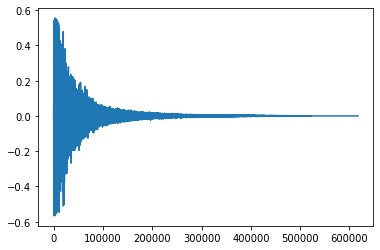

Listen to the first 1 second.


In [71]:
# Load example wave.
train_files = sorted(FSD2018_ROOT.glob('FSDKaggle2018.audio_train/*.wav'))

print(f'Training set has {len(train_files)} files. First file:', train_files[0])
waveform, sr = torchaudio.load(train_files[0])
plt.plot(waveform.t().numpy()); plt.show()
print('Listen to the first 1 second.')
Audio(waveform[0, :sr], rate=sr)

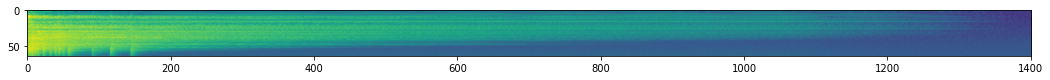

In [72]:
# Instantiate mel spectrogram converter 
to_mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=cfg.sample_rate, n_fft=cfg.n_fft, n_mels=cfg.n_mels,
    hop_length=cfg.hop_length, f_min=cfg.f_min, f_max=cfg.f_max)

# Waveform to log-mel spectrogram
log_mel_spec = to_mel_spectrogram(waveform).log()

plt.figure(figsize=(18,5))
plt.imshow(log_mel_spec[0])

## Preprocess audio files: convert to log-mel spectrogram

In [73]:
folders = ['FSDKaggle2018.audio_test', 'FSDKaggle2018.audio_train']

for folder in folders:
    cur_folder = FSD2018_ROOT/folder
    filenames = sorted(cur_folder.glob('*.wav'))
    for filename in filenames:
        # Load waveform
        waveform, sr = torchaudio.load(filename)
        assert sr == cfg.sample_rate
        # To log-mel spectrogram
        log_mel_spec = to_mel_spectrogram(waveform).log()
        # Write to work
        (WORK/folder).mkdir(parents=True, exist_ok=True)
        np.save(WORK/folder/filename.name.replace('.wav', '.npy'), log_mel_spec)

In [74]:
# Shows number of files converted
!ls -1R {WORK} | grep .npy | wc -l

11073


# Training Models

In [80]:
# Essential PyTorch
import torch
import torchaudio

# Other modules used in this notebook
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import Audio
import yaml
from easydict import EasyDict
from sklearn.model_selection import train_test_split


device = torch.device('cuda')
cfg.unit_length = int((cfg.clip_length * cfg.sample_rate + cfg.hop_length - 1) // cfg.hop_length)

print(cfg)

{'clip_length': 5.0, 'sample_rate': 44100, 'hop_length': 441, 'n_fft': 1024, 'n_mels': 64, 'f_min': 0, 'f_max': 22050, 'unit_length': 500}


In [81]:
### CONFIGURE YOURS ###
FSD2018_ROOT = Path('work')
WORK = Path('work')

In [82]:
# https://github.com/DCASE-REPO/dcase2018_baseline/blob/master/task2/evaluation.py
TOP_N = 3


def avg_precision(gts=None, topks=None):
    def one_ap(gt, topk):
        for (i, p) in enumerate(topk):
              if gt == p:
                    return 1.0 / (i + 1.0)
        return 0.0
    return np.array([one_ap(gt, topk) for gt, topk in zip(gts, topks)])


def eval_acc_map(model, device, dataloader, debug_name=None, n=3):
    model = model.to(device).eval()
    count = correct = ap = 0.0
    for _ in range(n):
        for X, gts in dataloader:
            preds = model(X.to(device))
            _, topks = torch.topk(preds, k=TOP_N, dim=1)
            topks = topks.cpu()
            correct += (topks[:, 0] == gts).sum()
            ap += avg_precision(gts, topks).sum()
            count += len(gts)
    acc = correct / count
    mAP = ap / count
    if debug_name:
        print(f'{debug_name} acc = {acc:.4f}, mAP@{TOP_N} = {mAP}')
    return acc, mAP

## FSDKaggle2018: Load meta data to variables

In [83]:
# Make lists of filenames and labels from meta files
filenames, labels = {}, {}
for split, npy_folder, meta_filename in [['train', 'work/FSDKaggle2018.audio_train', 'train_post_competition.csv'],
                                                                     ['test', 'work/FSDKaggle2018.audio_test', 'test_post_competition_scoring_clips.csv']]:
    df = pd.read_csv(FSD2018_ROOT/'FSDKaggle2018.meta'/meta_filename)
    filenames[split] = [(npy_folder + '/' + fname.replace('.wav', '.npy')) for fname in df.fname.values]
    labels[split] = list(df.label.values)

# Make a list of classes, converting labels into numbers
classes = sorted(set(labels['train'] + labels['test']))
for split in labels:
    labels[split] = [classes.index(label) for label in labels[split]]

print(filenames['train'][:3])
print(labels['train'][:3])
print(len(classes), classes[:3])

['work/FSDKaggle2018.audio_train/00044347.npy', 'work/FSDKaggle2018.audio_train/001ca53d.npy', 'work/FSDKaggle2018.audio_train/002d256b.npy']
[23, 30, 38]
41 ['Acoustic_guitar', 'Applause', 'Bark']


In [84]:
from sklearn.utils.class_weight import compute_class_weight


class_weight = compute_class_weight('balanced', range(len(classes)), labels['train'] )
print('class weight', class_weight)

filenames['train'], filenames['valid'], labels['train'], labels['valid'] = train_test_split(
     filenames['train'],  labels['train'], test_size=0.1, random_state=42)
print(f'Number of train/val files are = {len(filenames["train"])}/{len(filenames["valid"])}')
print('First 3 samples assigned to validation set:')
print(filenames['valid'][:3])
print(labels['valid'][:3])

class weight [0.7701626  0.7701626  0.9667313  0.7701626  1.10023229 2.11971358
 0.7701626  2.00911983 0.7701626  1.94158639 0.95081803 1.20967948
 0.7701626  1.46233405 1.5403252  0.7701626  1.9747759  0.7701626
 0.7701626  2.45796575 0.79126295 1.57176041 1.40029564 0.7701626
 1.66222144 0.82813183 0.7701626  1.49063729 1.58252589 0.7727384
 0.7701626  2.43209243 0.7701626  0.7701626  0.7701626  1.04546959
 0.7701626  1.9254065  0.7701626  0.7701626  0.85573622]
Number of train/val files are = 8525/948
First 3 samples assigned to validation set:
['work/FSDKaggle2018.audio_train/60f9e3ed.npy', 'work/FSDKaggle2018.audio_train/3e20cc09.npy', 'work/FSDKaggle2018.audio_train/e3278076.npy']
[17, 37, 1]


In [85]:
def sample_length(log_mel_spec):
    return log_mel_spec.shape[-1]


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, cfg, filenames, labels, transforms=None, normalize=False):
        assert len(filenames) == len(labels), f'Inconsistent length of filenames and labels.'

        self.filenames = filenames
        self.labels = labels
        self.transforms = transforms
        self.normalize = normalize

        # Calculate length of clip this dataset will make
        self.unit_length = cfg.unit_length

        # Test with first file
        assert self[0][0].shape[-1] == self.unit_length, f'Check your files, failed to load {filenames[0]}'

        # Show basic info.
        print(f'Dataset will yield log-mel spectrogram {len(self)} data samples in shape [1, {cfg.n_mels}, {self.unit_length}]')

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        assert 0 <= index and index < len(self)
        
        log_mel_spec = np.load(self.filenames[index])
        
        # normalize - instance based
        if self.normalize:
            _m, _s = log_mel_spec.mean(),  log_mel_spec.std() + np.finfo(np.float).eps
            log_mel_spec = (log_mel_spec - _m) / _s

        # Padding if sample is shorter than expected - both head & tail are filled with 0s
        pad_size = self.unit_length - sample_length(log_mel_spec)
        if pad_size > 0:
            offset = pad_size // 2
            log_mel_spec = np.pad(log_mel_spec, ((0, 0), (0, 0), (offset, pad_size - offset)), 'constant')

        # Random crop
        crop_size = sample_length(log_mel_spec) - self.unit_length
        if crop_size > 0:
            start = np.random.randint(0, crop_size)
            log_mel_spec = log_mel_spec[..., start:start + self.unit_length]

        # Apply augmentations
        log_mel_spec = torch.Tensor(log_mel_spec)
        if self.transforms is not None:
            log_mel_spec = self.transforms(log_mel_spec)

        return log_mel_spec, self.labels[index]


train_dataset = MyDataset(cfg, filenames['train'], labels['train'])
valid_dataset = MyDataset(cfg, filenames['valid'], labels['valid'])
test_dataset = MyDataset(cfg, filenames['test'], labels['test'])

BS = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BS, shuffle=True, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BS, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BS, pin_memory=True)

Dataset will yield log-mel spectrogram 8525 data samples in shape [1, 64, 500]
Dataset will yield log-mel spectrogram 948 data samples in shape [1, 64, 500]
Dataset will yield log-mel spectrogram 1600 data samples in shape [1, 64, 500]


In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy
from dlcliche.torch_utils import IntraBatchMixup


class MyLearner(pl.LightningModule):

    def __init__(self, model, learning_rate=3e-4, mixup_alpha=0.0, weight=None):
        super().__init__()
        self.learning_rate = learning_rate
        self.model = model
        self.criterion = nn.NLLLoss(weight=weight)
        self.batch_mixer = IntraBatchMixup(self.criterion, alpha=mixup_alpha) if mixup_alpha > 0.0 else None

    def forward(self, x):
        x = self.model(x)
        x = F.log_softmax(x, dim=1)
        return x

    def step(self, x, y, train):
        if self.batch_mixer is None:
            preds = self(x)
            loss = self.criterion(preds, y)
        else:
            x, stacked_ys = self.batch_mixer.transform(x, y, train=train)
            preds = self(x)
            loss = self.batch_mixer.criterion(preds, stacked_ys)
        return preds, loss

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds, loss = self.step(x, y, train=True)
        return loss

    def validation_step(self, batch, batch_idx, split='val'):
        x, y = batch
        preds, loss = self.step(x, y, train=False)
        yhat = torch.argmax(preds, dim=1)
        acc = accuracy(yhat, y)

        self.log(f'{split}_loss', loss, prog_bar=True)
        self.log(f'{split}_acc', acc, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx, split='test')

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return valid_loader

    def test_dataloader(self):
        return test_loader

In [94]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Mostly borrowed from https://github.com/pytorch/examples/blob/master/mnist/main.py
class Net(nn.Module):
    def __init__(self, n_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 256, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.pooling = nn.AdaptiveAvgPool2d((8, 8)) # extended
        self.fc1 = nn.Linear(16384, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = self.pooling(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [96]:
learner = MyLearner(Net(len(classes)))
checkpoint = pl.callbacks.ModelCheckpoint(monitor='val_acc')
trainer = pl.Trainer(gpus=1, max_epochs=1, callbacks=[checkpoint])
trainer.fit(learner)

learner.load_state_dict(torch.load(checkpoint.best_model_path)['state_dict'])
eval_acc_map(learner.model, device, learner.val_dataloader(), 'val')
eval_acc_map(learner.model, device, learner.test_dataloader(), 'test');

val acc = 0.2314, mAP@3 = 0.3216713548992031
test acc = 0.2110, mAP@3 = 0.3030902777777778


In [97]:
from models import resnetish18

learner = MyLearner(resnetish18(len(classes)))
checkpoint = pl.callbacks.ModelCheckpoint(monitor='val_acc')
trainer = pl.Trainer(gpus=1, max_epochs=1, callbacks=[checkpoint])
trainer.fit(learner)

learner.load_state_dict(torch.load(checkpoint.best_model_path)['state_dict'])
eval_acc_map(learner.model, device, learner.val_dataloader(), 'val')
eval_acc_map(learner.model, device, learner.test_dataloader(), 'test');

ModuleNotFoundError: ignored

In [98]:
from models import VGGish

learner = MyLearner(VGGish(len(classes)))
checkpoint = pl.callbacks.ModelCheckpoint(monitor='val_acc')
trainer = pl.Trainer(gpus=1, max_epochs=1, callbacks=[checkpoint])
trainer.fit(learner)

learner.load_state_dict(torch.load(checkpoint.best_model_path)['state_dict'])
eval_acc_map(learner.model, device, learner.val_dataloader(), 'val')
eval_acc_map(learner.model, device, learner.test_dataloader(), 'test');

config.yaml		  lightning_logs  requirements.txt	     work
Data-Preprocessing.ipynb  README.md	  Training-Classifier.ipynb
